<a href="https://colab.research.google.com/github/acg12/ml_projects/blob/main/Naive%20Bayes/ML_PENERIMAAN_MHS_NAIVE_BAYES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Penerimaan Calon Mahasiswa

## Setup Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/acg12/ml_projects/main/Naive%20Bayes/data.csv')
df.head()

,gmat,gpa,work experience,admitted
0,780,4.0,3,1
1,750,3.9,4,1
2,690,3.3,3,0
3,710,3.7,5,1
4,680,3.9,4,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gmat              40 non-null     int64  
 1   gpa               40 non-null     float64
 2   work  experience  40 non-null     int64  
 3   admitted          40 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 1.4 KB


## Splitting Data

In [4]:
X = df.loc[:, df.columns != 'admitted']
X.head()

,gmat,gpa,work experience
0,780,4.0,3
1,750,3.9,4
2,690,3.3,3
3,710,3.7,5
4,680,3.9,4


In [5]:
y = df[['admitted']]
y.head()

,admitted
0,1
1,1
2,0
3,1
4,0


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [7]:
print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_valid.shape}')

Train data shape: (30, 3)
Test data shape: (10, 3)


## Data Correlation

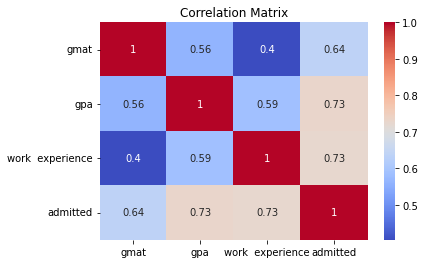

In [8]:
sns.heatmap(data=df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Tidak ada multicollinearity disini, semua kolom/variabel juga memiliki korelasi yang cukup baik dengan variable **admitted** di atas 0.5, sehingga kita tidak perlu membuang variable apapun.

## Normalize the Data

In [9]:
scaler = MinMaxScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
scaled_X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns, index=X_valid.index)
scaled_X_train.head()

,gmat,gpa,work experience
5,0.826087,0.869565,1.0
23,0.043478,0.434783,0.0
18,0.000000,0.434783,0.2
12,0.739130,0.869565,1.0
31,0.347826,0.434783,0.2


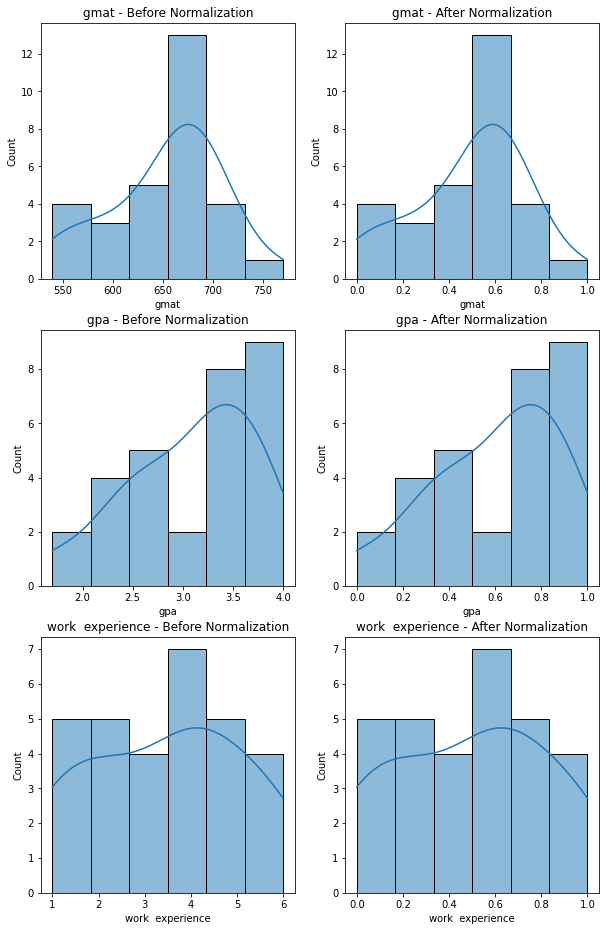

In [10]:
plt.figure(figsize=(10, 16))
cols = scaled_X_train.columns

for i, col in zip(range(1, len(cols)*2, 2), cols):
  # Before normalization
  plt.subplot(3, 2, i)
  sns.histplot(x=col, data=X_train, kde=True)
  plt.title(col + " - Before Normalization")

  # After normalization
  plt.subplot(3, 2, i+1)
  sns.histplot(x=col, data=scaled_X_train, kde=True)
  plt.title(col + " - After Normalization")

plt.show()

## Naive Bayesian

In [11]:
class naive_bayes_numerical:
  def __init__(self):
    pass

  def fit(self, X, y):
    self.params = {} # This is where we will store mean and stdev for P(gmat = x | admitted = 1), 
                     # P(gmat = x | admitted = 0), P(gpa = x | admitted = 1), and so forth
    self.class_prior = {} # This is where we will store class prior probability (in this case, 0 and 1)

    for col in X.columns:
      self.params[col] = {}

    data = pd.concat([X, y], axis=1)
    data = data.sort_values(by=['admitted'])
    self.classes = y['admitted'].unique()

    # Split into 2 tables
    # split_data[class_1] will contain X with y=class_1 and split_data[class_2] will contain X with y=class_2
    split_data = {}
    for cls in self.classes:
      split_data[cls] = data[data['admitted'] == cls].loc[:, data.columns != 'admitted']

    # Calculate mean and stdev for each group of data
    for i in split_data:
      for j in split_data[i]:
        self.params[j][i] = self.get_mean_stdev(split_data[i][j])

    # Calculate class prior probability (P(admitted = 0) and P(admitted = 1))
    for cls in self.classes:
      self.class_prior[cls] = len(split_data[cls]) / len(data)

  def get_mean_stdev(self, data):
    mean = data.mean()
    stdev = data.std()
    return {
        'mean': mean,
        'stdev': stdev
    }

  def predict(self, X):
    pred = []

    for i in range(len(X)):
      all_class_posterior = np.array([])
      for cls in self.classes:
        posterior = 1
        for col in X.columns:
          value = X.iloc[i][col]
          mean = self.params[col][cls]['mean']
          stdev = self.params[col][cls]['stdev']
          fx = (1 / (np.sqrt(2 * np.pi) * stdev)) * np.exp(-1 * ((value - mean) ** 2 / (2 * stdev**2)))
          posterior *= fx
        all_class_posterior = np.append(all_class_posterior, posterior)
      pred.append(self.classes[np.argmax(all_class_posterior)])
    return pred

In [12]:
model = naive_bayes_numerical()
model.fit(scaled_X_train, y_train)

## Predict and Evaluate

### Validation Data

In [13]:
y_val_pred = model.predict(scaled_X_valid)
y_val_pred

[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

In [14]:
y_val_true = y_valid['admitted']
temp = pd.DataFrame({
    'y_pred': y_val_pred,
    'y_true': y_val_true
})

pd.concat([scaled_X_valid, temp], axis=1)

,gmat,gpa,work experience,y_pred,y_true
15,0.304348,0.565217,0.0,0,0
27,0.173913,0.260870,0.2,0,0
25,0.565217,0.695652,1.0,1,1
16,0.173913,0.434783,0.6,0,0
17,0.478261,0.869565,1.0,1,1
37,0.173913,0.695652,0.0,0,0
8,0.869565,0.695652,0.8,1,1
0,1.043478,1.000000,0.4,1,1
1,0.913043,0.956522,0.6,1,1
21,0.260870,0.130435,0.0,0,0


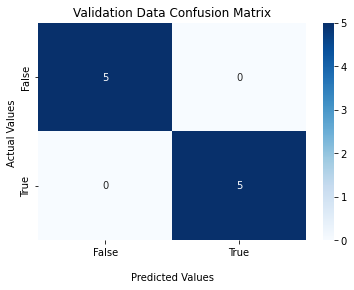

In [15]:
cf_matrix = confusion_matrix(y_val_true, y_val_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Validation Data Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [16]:
print('Accuracy score:', accuracy_score(y_val_true, y_val_pred))
print('Precision score:', precision_score(y_val_true, y_val_pred))
print('Recall score:', recall_score(y_val_true, y_val_pred))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0


In [17]:
print(classification_report(y_val_true, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



Dari sini kita bisa melihat, bahwa prediksi model kita cukup bagus untuk validation data kita. Model Naive Bayes kita berhasil mengklasifikasi semua data dengan benar.

### Test data

In [18]:
X_test = pd.read_csv('https://raw.githubusercontent.com/acg12/ml_projects/main/Naive%20Bayes/test.csv')
X_test.shape

(5, 3)

In [19]:
X_test.columns = X_train.columns

In [20]:
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [21]:
y_test_pred = model.predict(scaled_X_test)
y_test_pred

[0, 1, 1, 0, 1]

Berikut prediksi model kita terhadap novel data.

In [22]:
pd.concat([scaled_X_test, pd.Series(y_test_pred, name='y_pred')], axis=1)

,gmat,gpa,work experience,y_pred
0,0.217391,0.130435,0.4,0
1,0.869565,0.869565,0.6,1
2,0.608696,0.695652,1.0,1
3,0.304348,0.260870,0.0,0
4,0.739130,0.565217,0.8,1
